# DATASET A: LOAN

In [1657]:
# import library
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import pickle
import os

In [1658]:
# read dataset
df = pd.read_csv("Dataset_A_loan.csv")
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [1659]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   42750 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

It shows that the data type of the all columns is already as it should be

In [1661]:
class DataHandler:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.input_df = None
        self.output_df = None

    def load_data(self):
        self.data = pd.read_csv(self.file_path)

    def create_input_output(self, target_column):
        self.output_df = self.data[target_column]
        self.input_df = self.data.drop(target_column, axis=1)

In [1662]:
filePath = "Dataset_A_loan.csv"
dataHandler = DataHandler(file_path=filePath)
dataHandler.load_data()
dataHandler.create_input_output("loan_status")
inputDF = dataHandler.input_df
outputDF = dataHandler.output_df

In [1663]:
outputDF.head()

0    1
1    0
2    1
3    1
4    1
Name: loan_status, dtype: int64

In [1664]:
class ModelHandler:
    def __init__(self, input_data, output_data, seed):
        self.input_data = input_data
        self.output_data = output_data
        self.SEED = seed
        self.createRFModel()
        self.createXGBModel()
        self.model = None
        self.x_train, self.x_test, self.y_train, self.y_test, self.y_predict = [None] * 5

    def createRFModel(self, criteria="gini", maxdepth=6):
        self.RFModel = RandomForestClassifier(criterion=criteria, max_depth=maxdepth, random_state=self.SEED)
        self.model = self.RFModel
        
    def createXGBModel(self, max_depth=6, learning_rate=0.1, n_estimators=100):
        self.XGBModel = XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, random_state=self.SEED)
        self.model = self.XGBModel 

    def setModel(self, model_name='rf'):
        if model_name.lower() == 'rf':
            self.model = self.RFModel
        elif model_name.lower() == 'xgb':
            self.model = self.XGBModel
            
    def checkingUniqueValue(self, columns):
        for column in columns:
            print(f"Column: {column}")
            unique_values = self.input_data[column].unique()
            num_unique = len(unique_values)
            print(f"  Total unique values: {num_unique}")
            
            # Tampilkan isinya kalau uniknya ≤ 10 biar gak panjang
            if num_unique <= 10:
                print(f"  Unique values: {unique_values}")
            else:
                print("  (Too many to display)")
            
            print("-" * 50)

    def checkingDistribution(self, columns):
        for column in columns:
            plt.figure(figsize=(12, 5))
    
            # histogram
            plt.subplot(1, 2, 1)
            sns.histplot(self.input_data[column], kde=True, bins=20, color='skyblue')
            plt.title(f"Histogram of {column}")
            plt.xlabel(column)
            plt.ylabel("Frequency")
    
            # boxplot
            plt.subplot(1, 2, 2)
            sns.boxplot(y=self.input_data[column], color='lightgreen')
            plt.title(f"Boxplot of {column}")
            plt.xlabel(column)
    
            plt.tight_layout()
            plt.show()

    def checkMissingValue(self, columns):
        total_rows = len(self.input_data)
        for column in columns:
            print(f"Column: {column}")
            missing_count = self.input_data[column].isnull().sum()
            missing_percent = (missing_count / total_rows) * 100
            print(f"  Missing values: {missing_count} ({missing_percent:.2f}%)\n")
            
    def dropMissingValue(self, columns):
        self.input_data.dropna(subset=columns, inplace=True)
        self.output_data = self.output_data.loc[self.input_data.index]
        print("Missing values have been handled.")

    def handleGender(self):
        gender_map = {
            'female': 'Female',
            'fe male': 'Female',
            'male': 'Male'
        }
        self.input_data['person_gender'] = self.input_data['person_gender'].str.strip().map(gender_map).fillna(self.input_data['person_gender'])
    
    def handleAge(self):
        self.input_data = self.input_data[
            (self.input_data['person_age'] >= 21) & (self.input_data['person_age'] <= 70)]
        self.output_data = self.output_data.loc[self.input_data.index]
        print("Age column have been handled.")        

    def encodeGender(self, columns):
        self.genderEncoder = OrdinalEncoder(categories = [["Female", "Male"]])
        self.input_data[columns] = self.genderEncoder.fit_transform(self.input_data[[columns]])

    def encodeEducation(self, columns):
        self.educationEncoder = OrdinalEncoder(categories = [["High School", "Associate", "Bachelor", "Master", "Doctorate"]])
        self.input_data[columns] = self.educationEncoder.fit_transform(self.input_data[[columns]])

    def encodeHomeOwnership(self, columns):
        self.homeOwnershipEncoder = OrdinalEncoder(categories = [["OTHER", "RENT", "MORTGAGE", "OWN"]])
        self.input_data[columns] = self.homeOwnershipEncoder.fit_transform(self.input_data[[columns]])

    def encodeLoanIntent(self, columns):
        self.loanIntentEncoder = OrdinalEncoder(categories = [["MEDICAL", "EDUCATION", "DEBTCONSOLIDATION", "HOMEIMPROVEMENT", "PERSONAL", "VENTURE"]])
        self.input_data[columns] = self.loanIntentEncoder.fit_transform(self.input_data[[columns]])

    def encodePreviousFile(self, columns):
        self.previousFileEncoder = OrdinalEncoder(categories = [["No", "Yes"]])
        self.input_data[columns] = self.previousFileEncoder.fit_transform(self.input_data[[columns]])
    
    def splitData(self, test_size = 0.2):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.input_data, self.output_data, test_size=test_size, random_state=self.SEED)

    def check_distribution(self):
        for column in self.df.columns:
            print(f"Column: {column}")
            value_counts = self.df[column].value_counts()
            print(value_counts)
            print("-" * 50)

    def scalingAge (self, columns):
        self.ageScaler = RobustScaler()
        self.x_train[columns] = self.ageScaler.fit_transform(self.x_train[[columns]])
        self.x_test[columns] = self.ageScaler.transform(self.x_test[[columns]])

    def scalingIncome(self, columns):
        self.incomeScaler = RobustScaler()
        self.x_train[columns] = self.incomeScaler.fit_transform(self.x_train[[columns]])
        self.x_test[columns] = self.incomeScaler.transform(self.x_test[[columns]])

    def scalingEmpExp(self, columns):
        self.empExpScaler = RobustScaler()
        self.x_train[columns] = self.empExpScaler.fit_transform(self.x_train[[columns]])
        self.x_test[columns] = self.empExpScaler.transform(self.x_test[[columns]])
        
    def scalingLoanAmount(self, columns):
        self.loanAmountScaler = RobustScaler()
        self.x_train[columns] = self.loanAmountScaler.fit_transform(self.x_train[[columns]])
        self.x_test[columns] = self.loanAmountScaler.transform(self.x_test[[columns]])
        
    def scalingIntRate(self, columns):
        self.intRateScaler = RobustScaler()
        self.x_train[columns] = self.intRateScaler.fit_transform(self.x_train[[columns]])
        self.x_test[columns] = self.intRateScaler.transform(self.x_test[[columns]])
        
    def scalingLoanPercent(self, columns):
        self.loanPercentScaler = RobustScaler()
        self.x_train[columns] = self.loanPercentScaler.fit_transform(self.x_train[[columns]])
        self.x_test[columns] = self.loanPercentScaler.transform(self.x_test[[columns]])
        
    def scalingPersonCred(self, columns):
        self.personCredScaler = RobustScaler()
        self.x_train[columns] = self.personCredScaler.fit_transform(self.x_train[[columns]])
        self.x_test[columns] = self.personCredScaler.transform(self.x_test[[columns]])
        
    def scalingCreditScore(self, columns):
        self.creditScoreScaler = RobustScaler()
        self.x_train[columns] = self.creditScoreScaler.fit_transform(self.x_train[[columns]])
        self.x_test[columns] = self.creditScoreScaler.transform(self.x_test[[columns]])
    
    def trainModel(self):
        self.model.fit(self.x_train, self.y_train)

    def prediction(self):
        self.y_predict = self.model.predict(self.x_test)

    def evaluateModel(self):
        accuracy = accuracy_score(self.y_test, self.y_predict)
        print("Accuracy score: ", accuracy)

    def createReport(self):
        print("\nClassification Report\n")
        print(classification_report(self.y_test, self.y_predict, target_names=["Denied","Approved"]))

    def saveAllPKL(self, folder="AllPickle"):

        os.makedirs(folder, exist_ok=True)
        
        models = {
            "RFModel.pkl": self.RFModel,
            "XGBModel.pkl": self.XGBModel,
        }
        
        for filename, model_obj in models.items():
            with open(os.path.join(folder, filename), "wb") as file:
                pickle.dump(model_obj, file)

        encoders = {
            "genderEncoder.pkl": self.genderEncoder,
            "educationEncoder.pkl": self.educationEncoder,
            "homeOwnershipEncoder.pkl": self.homeOwnershipEncoder,
            "loanIntentEncoder.pkl": self.loanIntentEncoder,
            "previousFileEncoder.pkl": self.previousFileEncoder
        }

        for filename, encoder in encoders.items():
            with open(os.path.join(folder, filename), "wb") as file:
                pickle.dump(encoder, file)

        scalers = {
            "ageScaler.pkl": self.ageScaler,
            "incomeScaler.pkl": self.incomeScaler,
            "empExpScaler.pkl": self.empExpScaler,
            "loanAmountScaler.pkl": self.loanAmountScaler,
            "intRateScaler.pkl": self.intRateScaler,
            "loanPercentScaler.pkl": self.loanPercentScaler,
            "personCredScaler.pkl": self.personCredScaler,
            "creditScoreScaler.pkl": self.creditScoreScaler            
        }
    
        for filename, scaler in scalers.items():
            with open(os.path.join(folder, filename), "wb") as file:
                pickle.dump(scaler, file)

        print("\nPickle successfully exported\n")
        

## Checking Unique Value

In [1666]:
# before we handle the outlier lets check the unique value for each variable
for column in df.columns:
    print(f"Column: {column}")
    value_counts = df[column].value_counts()
    print(value_counts)
    print("-" * 50)

Column: person_age
person_age
23.0     5254
24.0     5138
25.0     4507
22.0     4236
26.0     3659
27.0     3095
28.0     2728
29.0     2455
30.0     2021
31.0     1645
32.0     1403
21.0     1289
33.0     1240
34.0      980
35.0      847
36.0      740
37.0      666
38.0      503
39.0      389
40.0      349
41.0      303
42.0      247
43.0      215
44.0      177
45.0      135
46.0      114
47.0      112
48.0       93
49.0       59
50.0       56
51.0       46
52.0       42
53.0       35
54.0       24
55.0       24
58.0       20
56.0       20
57.0       17
20.0       17
60.0       16
61.0       12
66.0       11
65.0       10
70.0        7
64.0        7
62.0        7
59.0        6
69.0        5
144.0       3
73.0        3
63.0        3
123.0       2
78.0        1
94.0        1
80.0        1
84.0        1
76.0        1
67.0        1
116.0       1
109.0       1
Name: count, dtype: int64
--------------------------------------------------
Column: person_gender
person_gender
male       24799


In [1667]:
columnsUnique = ["person_gender", "person_education", "person_home_ownership", "loan_intent", "previous_loan_defaults_on_file"]

modelHandler.checkingUniqueValue(columnsUnique)

Column: person_gender
  Total unique values: 2
  Unique values: [0. 1.]
--------------------------------------------------
Column: person_education
  Total unique values: 5
  Unique values: [3. 0. 2. 1. 4.]
--------------------------------------------------
Column: person_home_ownership
  Total unique values: 4
  Unique values: [1. 3. 2. 0.]
--------------------------------------------------
Column: loan_intent
  Total unique values: 6
  Unique values: [4. 1. 0. 5. 3. 2.]
--------------------------------------------------
Column: previous_loan_defaults_on_file
  Total unique values: 2
  Unique values: [0. 1.]
--------------------------------------------------


## Checking Missing Value

In [1669]:
modelHandler = ModelHandler(inputDF, outputDF, seed=777)

# check duplicate and missing values
modelHandler.checkMissingValue(["person_age", "person_gender", "person_education", "person_income",
 "person_emp_exp", "person_home_ownership", "loan_amnt", "loan_intent",
 "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length",
 "credit_score", "previous_loan_defaults_on_file"])

Column: person_age
  Missing values: 0 (0.00%)

Column: person_gender
  Missing values: 0 (0.00%)

Column: person_education
  Missing values: 0 (0.00%)

Column: person_income
  Missing values: 2250 (5.00%)

Column: person_emp_exp
  Missing values: 0 (0.00%)

Column: person_home_ownership
  Missing values: 0 (0.00%)

Column: loan_amnt
  Missing values: 0 (0.00%)

Column: loan_intent
  Missing values: 0 (0.00%)

Column: loan_int_rate
  Missing values: 0 (0.00%)

Column: loan_percent_income
  Missing values: 0 (0.00%)

Column: cb_person_cred_hist_length
  Missing values: 0 (0.00%)

Column: credit_score
  Missing values: 0 (0.00%)

Column: previous_loan_defaults_on_file
  Missing values: 0 (0.00%)



it shows that the missing value of the person_education is 5% so we will handle it by drop the rows

## Drop Missing Value

In [1672]:
modelHandler.dropMissingValue(["person_income"])

Missing values have been handled.


## Handling Columns

### Handling Gender Columns

In [1675]:
modelHandler.handleGender()

In [1676]:
columnsUnique = ["person_gender", "person_education", "person_emp_exp", "person_home_ownership", "loan_intent"]
modelHandler.checkingUniqueValue(columnsUnique)

Column: person_gender
  Total unique values: 2
  Unique values: ['Female' 'Male']
--------------------------------------------------
Column: person_education
  Total unique values: 5
  Unique values: ['Master' 'High School' 'Bachelor' 'Associate' 'Doctorate']
--------------------------------------------------
Column: person_emp_exp
  Total unique values: 62
  (Too many to display)
--------------------------------------------------
Column: person_home_ownership
  Total unique values: 4
  Unique values: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
--------------------------------------------------
Column: loan_intent
  Total unique values: 6
  Unique values: ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
--------------------------------------------------


### Handling Age Columns

In [1678]:
modelHandler.handleAge()

Age column have been handled.


the configuration gender and age is succesful

In [1680]:
modelHandler.input_data.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score
count,42721.000000,4.272100e+04,42721.000000,42721.000000,42721.000000,42721.000000,42721.000000,42721.000000
mean,27.737600,7.990785e+04,5.382084,9590.510498,11.005122,0.139708,5.859250,632.642307
std,5.861152,6.303681e+04,5.878085,6323.180454,2.979765,0.087093,3.865217,50.375962
min,21.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000
25%,24.000000,4.726200e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,602.000000
50%,26.000000,6.705000e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000
75%,30.000000,9.579700e+04,8.000000,12250.000000,12.990000,0.190000,8.000000,670.000000
max,70.000000,2.448661e+06,50.000000,35000.000000,20.000000,0.660000,30.000000,784.000000


In [ ]:
st.subheader("Input Loan Data")

age = st.slider('Age', min_value=21, max_value=70, value=21)
income = st.number_input('Annual Income', value=2.448661e+06)
emp_length = st.slider('Employment Length (Years)', min_value=0, max_value=40, value=5)
loan_amount = st.number_input('Loan Amount', value=10000.0)
int_rate = st.slider('Interest Rate (%)', min_value=0.0, max_value=30.0, value=12.5)
loan_percent_income = st.slider('Loan Percent of Income (%)', min_value=0.0, max_value=100.0, value=10.0)
person_cred = st.slider('Credit History Length (Years)', min_value=0.0, max_value=50.0, value=10.0)
credit_score = st.slider('Credit Score', min_value=300, max_value=850, value=600)


## Check Distribution

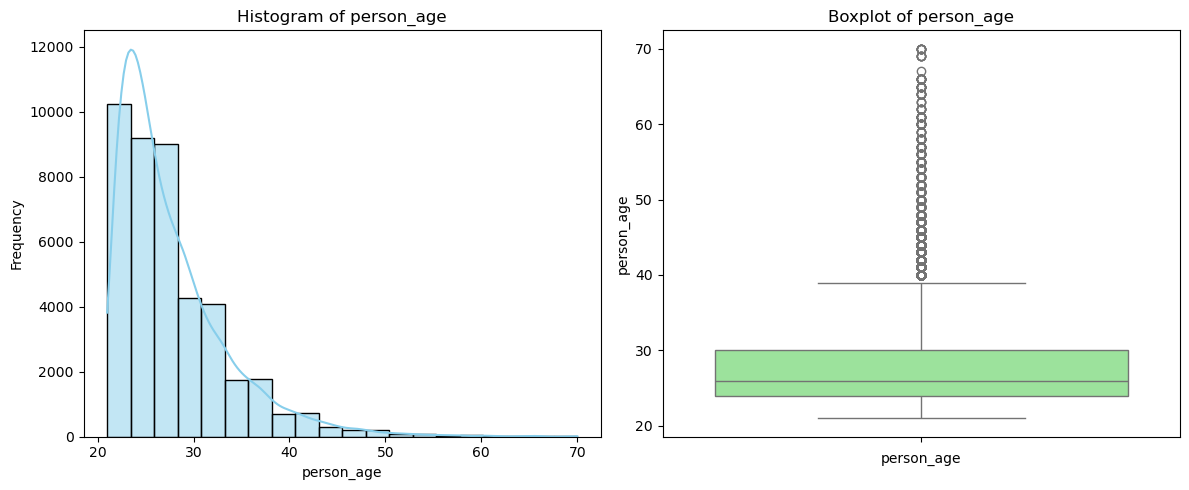

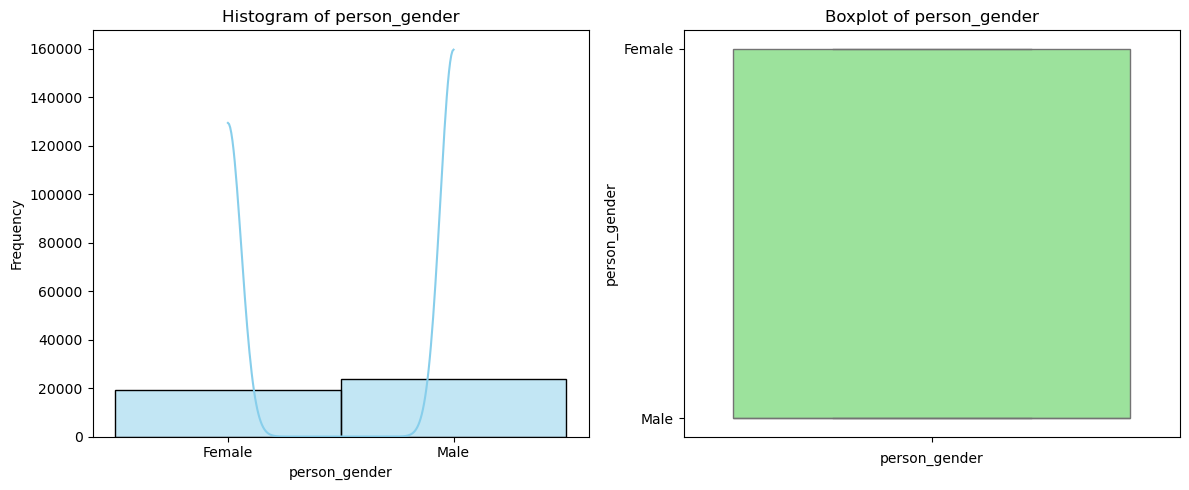

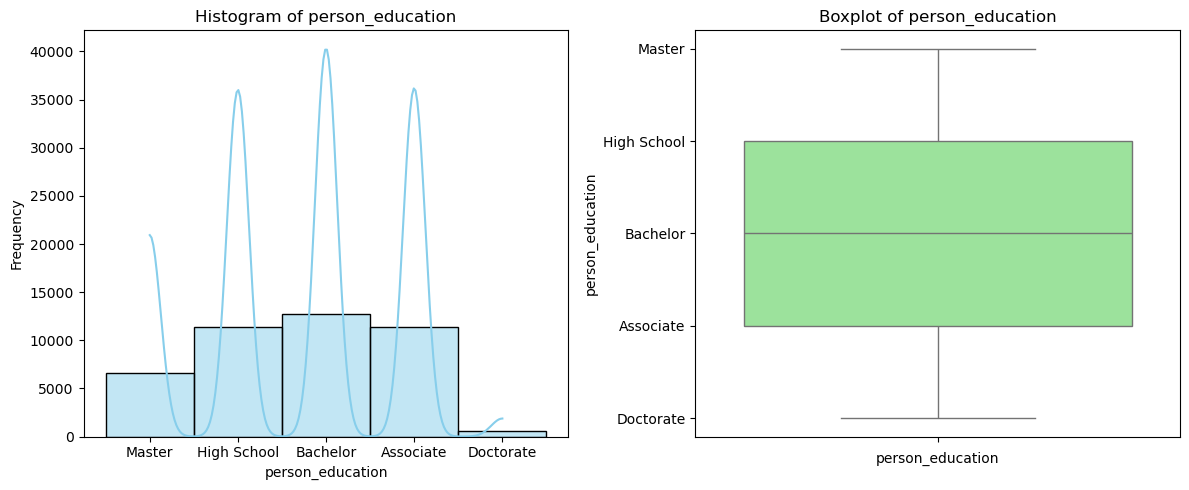

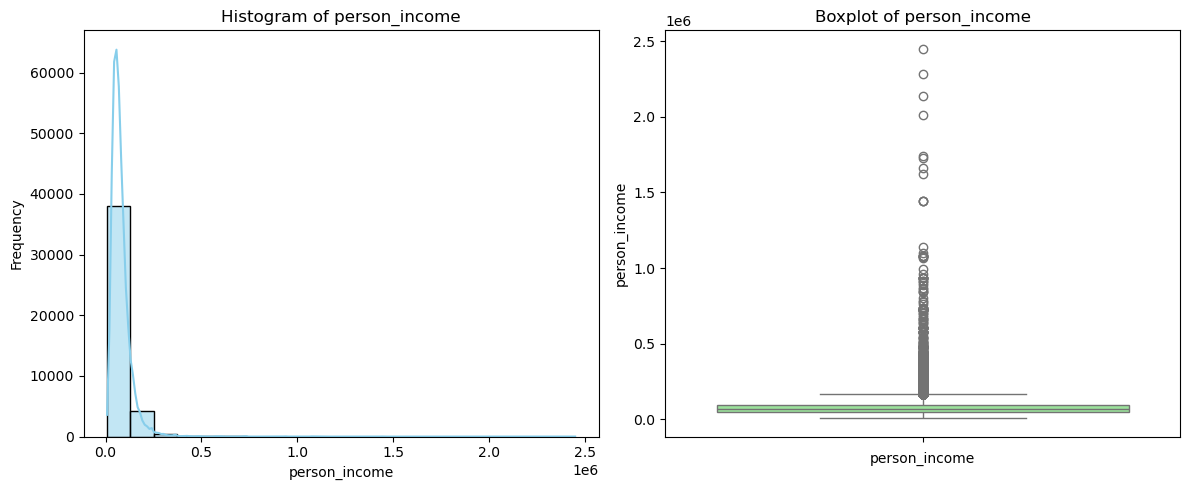

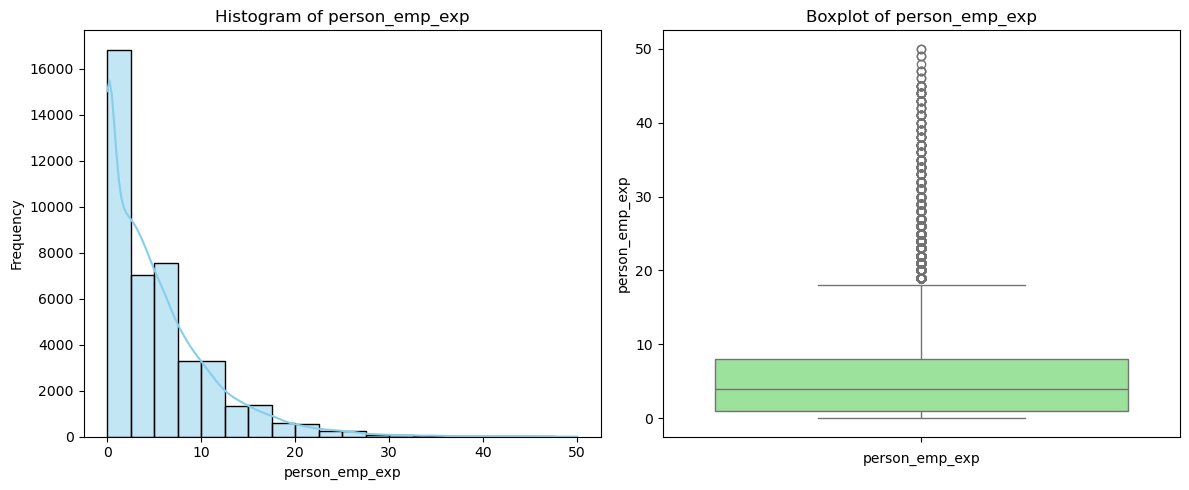

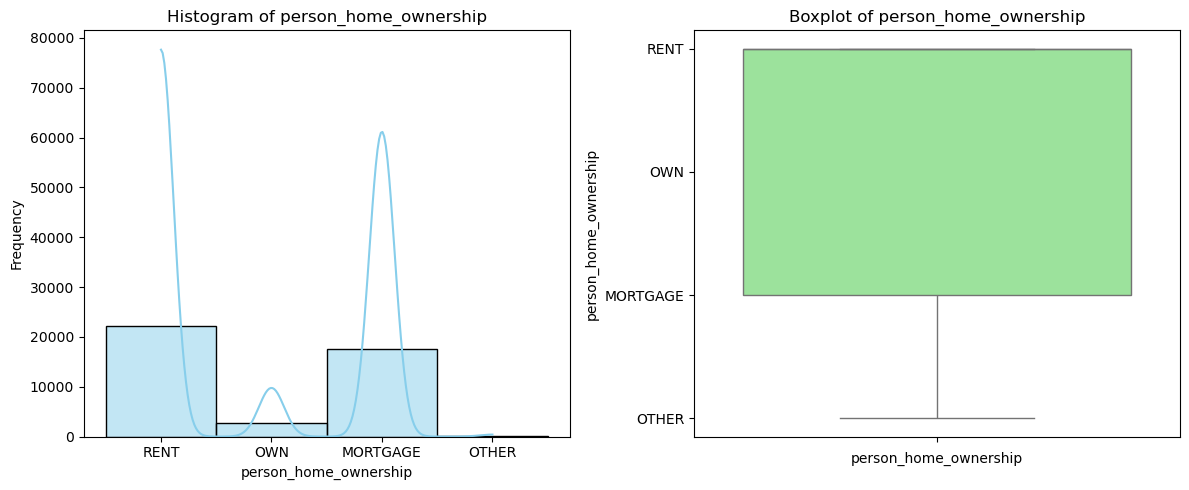

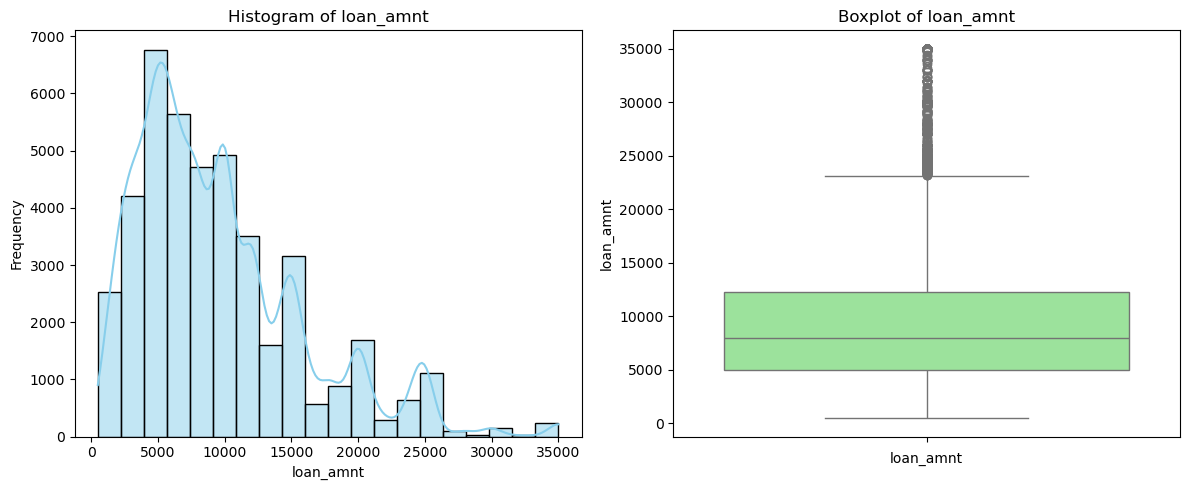

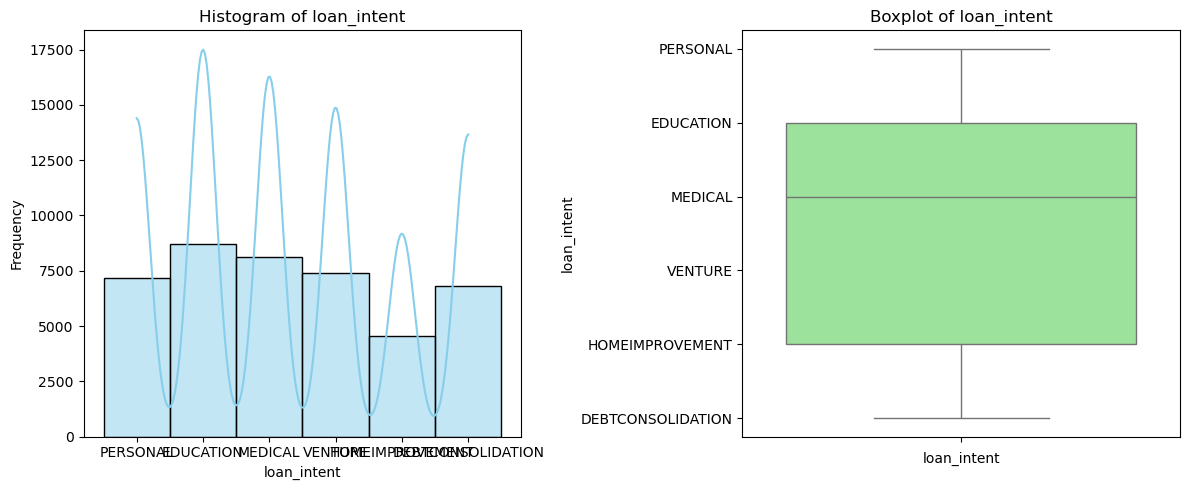

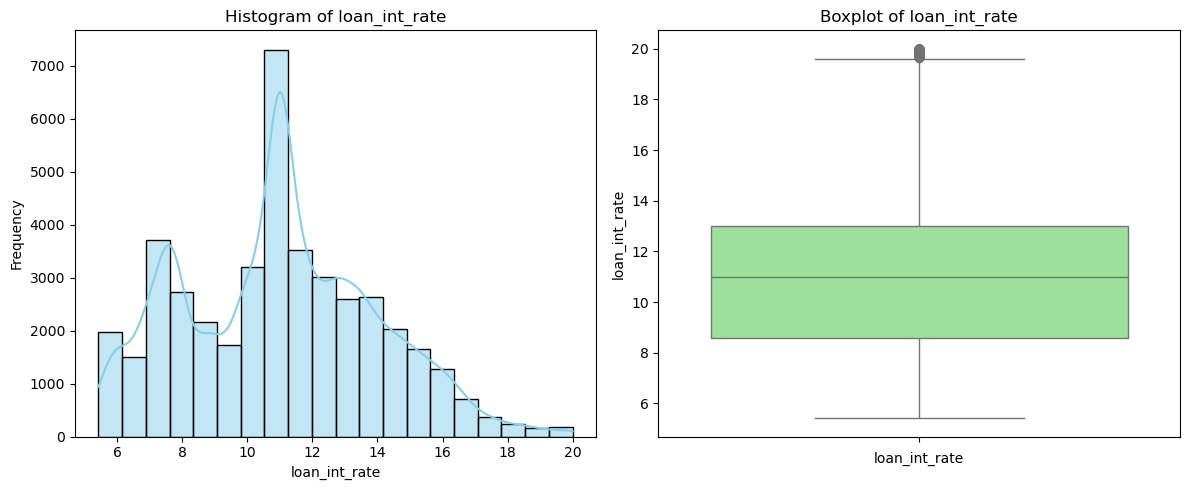

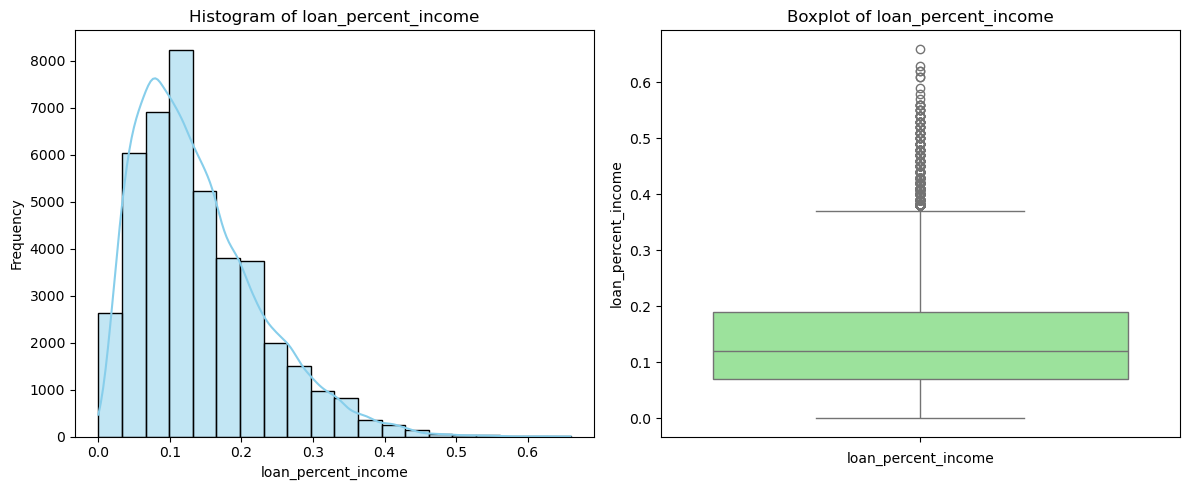

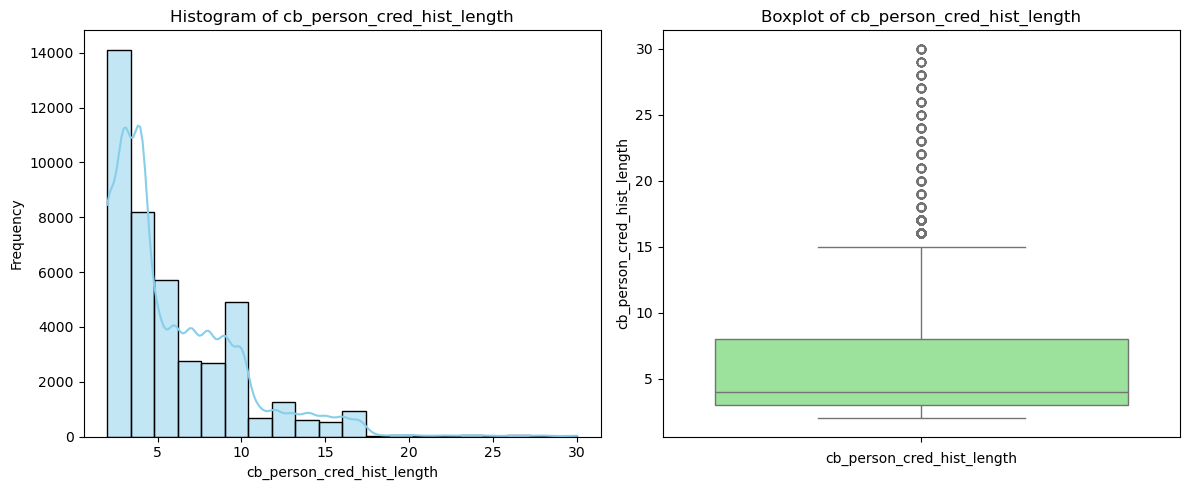

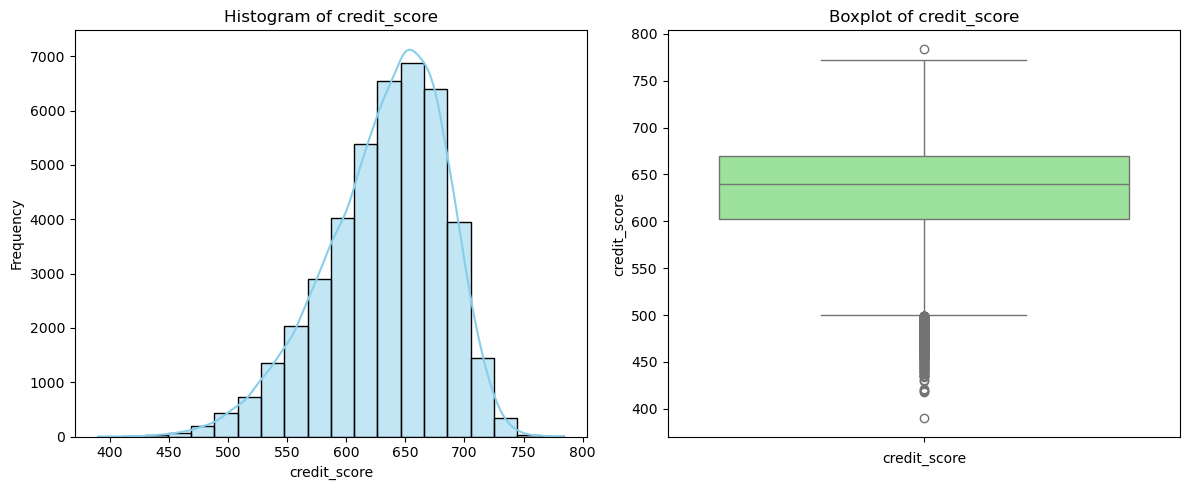

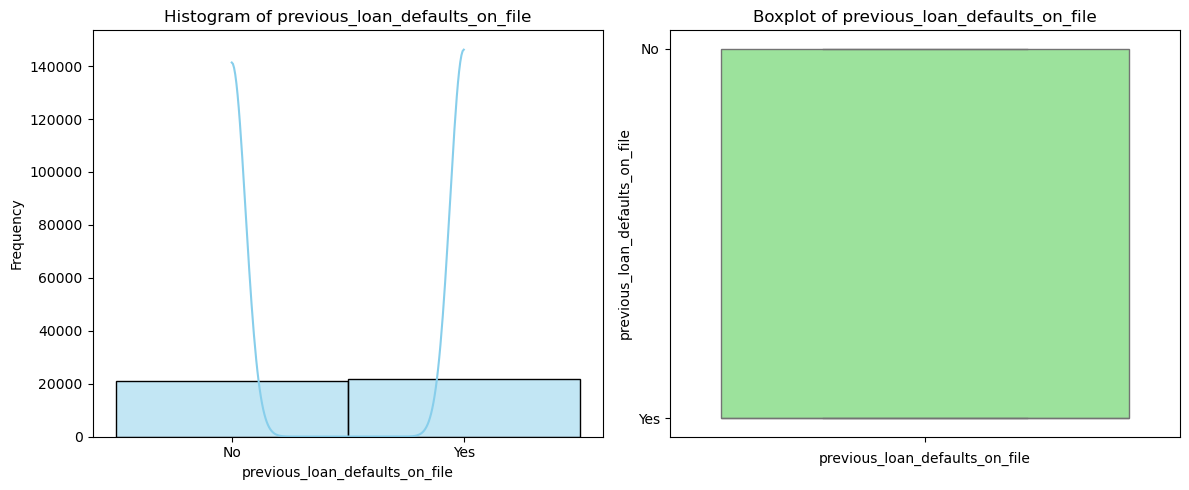

In [1682]:
# check distribution
# modelHandler.checkingDistribution(["person_age", "person_income", "loan_amnt", "loan_percent_income", "credit_score" ])
modelHandler.checkingDistribution(["person_age", "person_gender", "person_education", "person_income",
 "person_emp_exp", "person_home_ownership", "loan_amnt", "loan_intent",
 "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length",
 "credit_score", "previous_loan_defaults_on_file"])

In [1683]:
modelHandler.encodeGender("person_gender")
modelHandler.encodeEducation("person_education")
modelHandler.encodeHomeOwnership("person_home_ownership")
modelHandler.encodeLoanIntent("loan_intent")
modelHandler.encodePreviousFile("previous_loan_defaults_on_file")

/var/folders/x0/dk0j56b52k99y825zm1b_s140000gn/T/ipykernel_1434/214137090.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.input_data[columns] = self.genderEncoder.fit_transform(self.input_data[[columns]])
/var/folders/x0/dk0j56b52k99y825zm1b_s140000gn/T/ipykernel_1434/214137090.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.input_data[columns] = self.educationEncoder.fit_transform(self.input_data[[columns]])
/var/folders/x0/dk0j56b52k99y825zm1b_s140000gn/T/ipykernel_1434/214137090.py:97

In [1684]:
modelHandler.splitData()

In [1685]:
modelHandler.scalingAge("person_age")
modelHandler.scalingIncome("person_income")
modelHandler.scalingEmpExp("person_emp_exp")
modelHandler.scalingLoanAmount("loan_amnt")
modelHandler.scalingIntRate("loan_int_rate")
modelHandler.scalingLoanPercent("loan_percent_income")
modelHandler.scalingPersonCred("cb_person_cred_hist_length")
modelHandler.scalingCreditScore("credit_score")

In [1686]:
modelHandler.input_data.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
0,22.0,0.0,3.0,71948.0,0,1.0,35000.0,4.0,16.02,0.49,3.0,561,0.0
1,21.0,0.0,0.0,12282.0,0,3.0,1000.0,1.0,11.14,0.08,2.0,504,1.0
2,25.0,0.0,0.0,12438.0,3,2.0,5500.0,0.0,12.87,0.44,3.0,635,0.0
3,23.0,0.0,2.0,79753.0,0,1.0,35000.0,0.0,15.23,0.44,2.0,675,0.0
4,24.0,1.0,3.0,66135.0,1,1.0,35000.0,0.0,14.27,0.53,4.0,586,0.0


## Model

## Random Forest Model

In [1689]:
print("Random Forest Model Result:")
modelHandler.setModel('rf') 
modelHandler.trainModel()
modelHandler.prediction()
modelHandler.evaluateModel()
modelHandler.createReport()

Random Forest Model Result:
Accuracy score:  0.9122293739028672

Classification Report

              precision    recall  f1-score   support

      Denied       0.92      0.98      0.95      6607
    Approved       0.89      0.70      0.78      1938

    accuracy                           0.91      8545
   macro avg       0.91      0.84      0.86      8545
weighted avg       0.91      0.91      0.91      8545



In [1690]:
print("XGB Model Result:")
modelHandler.setModel('xgb') 
modelHandler.trainModel()
modelHandler.prediction()
modelHandler.evaluateModel()
modelHandler.createReport()

XGB Model Result:
Accuracy score:  0.9258045640725571

Classification Report

              precision    recall  f1-score   support

      Denied       0.94      0.97      0.95      6607
    Approved       0.88      0.77      0.83      1938

    accuracy                           0.93      8545
   macro avg       0.91      0.87      0.89      8545
weighted avg       0.92      0.93      0.92      8545



In [1691]:
modelHandler.saveAllPKL()


Pickle successfully exported

